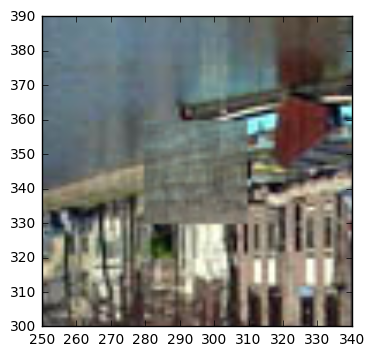

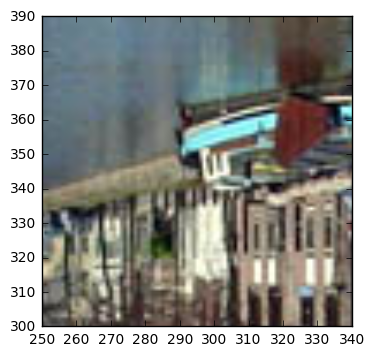

In [25]:
%matplotlib inline

import random
import operator
import matplotlib.pyplot as plt
import math
import numpy as np
import os

import netCDF4
import matplotlib.pyplot as plt
from PIL import Image

from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000

from deap import base, creator, gp, tools

class Imager(object):
    def __init__(self, srcimage):
        self.srcimage = srcimage
        
    def PunchHole(self, dx, dy):
        self.imghole = Image.open(self.srcimage).copy().convert('RGBA')
        self.imgholePA = self.imghole.load()
        self.xHole = 280 #950
        self.yHole = 330 #730
        (self.xMax, self.yMax) = self.imghole.size
        self.dx = dx
        self.dy = dy
        for x in range(self.xHole, self.xHole + self.dx):
            for y in range(self.yHole, self.yHole + self.dy):
                if self.imgholePA[x, y] != (255, 255, 255, 255):
                    self.imgholePA[x, y] = (0, 0, 0, 0)
        self.imghole.save(self.srcimage.replace(r'.png', r'_hole.png'))

    def FindPixelInDirection(self, x, y, rx, ry):
        if rx == 0 and ry == 0:
            return None
        found = False
        cx = x
        cy = y
        while not found:
            cx += rx
            cy += ry
            if cx < 0 or cx >= self.xMax:
                break
            if cy < 0 or cy >= self.yMax:
                break
            pixel = self.imgholePA[cx, cy]
            if pixel != (255, 255, 255, 255) and pixel != (0, 0, 0, 0):
                found = True
        return pixel if found else None
    
    def ApplyIndividual(self, lst, dstimage):
        self.workimage = self.imghole.copy()
        self.workimagePA = self.workimage.load()
        pixels = list(lst)
        numPairs = len(pixels) / 2
        for x in range(self.xHole, self.xHole + self.dx):
            for y in range(self.yHole, self.yHole + self.dy):
                nr = 0
                ng = 0
                nb = 0
                pixelsFound = 0
                if self.imgholePA[x,y] == (0, 0, 0, 0):
                    for i in range(0, numPairs):
                        rx = pixels[2 * i]
                        ry = pixels[2 * i + 1]
                        newPixel = self.FindPixelInDirection(x, y, rx, ry)
                        if newPixel != None:
                            pixelsFound += 1
                            nr += newPixel[0]
                            ng += newPixel[1]
                            nb += newPixel[2]
#                             print nr
#                             print ng
#                             print nb
#                             print numPairs
                    if pixelsFound > 0:
                        self.workimagePA[x, y] = (nr / numPairs, ng / numPairs, nb / numPairs, 255)
                    else:
                        print r'no pixels found!'
        self.workimage.save(dstimage)
        self.workimage.close() 
    
    def EvaluateIndividual(self, dstimage):
        refimg = Image.open(self.srcimage)
        refimgPA = refimg.load()
        cmpimg = Image.open(dstimage)
        cmpimgPA = cmpimg.load()
        
        score = 0
        scores = []
        for x in range(self.xHole, self.xHole + self.dx):
            for y in range(self.yHole, self.yHole + self.dy):
                if self.imgholePA[x, y] != (255, 255, 255, 255):
                    s = refimgPA[x, y]
                    c = cmpimgPA[x, y]
                    
                    colorS_rgb = sRGBColor(s[0], s[1], s[2])
                    colorC_rgb = sRGBColor(c[0], c[1], c[2])

                    colorS_lab = convert_color(colorS_rgb, LabColor)
                    colorC_lab = convert_color(colorC_rgb, LabColor)
                    scores.append(delta_e_cie2000(colorS_lab, colorC_lab))
#                     score += pow(s[0] - c[0], 2) + \
#                              pow(s[1] - c[1], 2) + \
#                              pow(s[2] - c[2], 2)

        refimg.close()
        cmpimg.close()
        
        compute1 = [100*x for x in scores if x < 50]
        compute2 = [x for x in scores if 50 < x < 100]
        compute3 = [.001 * x for x in scores if x >= 100]
        score = sum(compute1) + sum(compute2) + sum(compute3)

        return score
    
    def DisplayFilledRegion(self, dstimage):
        img = Image.open(dstimage)
        plt.imshow(np.asarray(img))
        plt.xlim(self.xHole - self.dx, self.xHole + self.dx * 2)
        plt.ylim(self.yHole - self.dy, self.yHole + self.dy * 2)
        plt.show()
        img.close()    

    def DisplayReference(self):
        img = Image.open(self.srcimage)
        plt.imshow(np.asarray(img))
        plt.xlim(self.xHole - self.dx, self.xHole + self.dx * 2)
        plt.ylim(self.yHole - self.dy, self.yHole + self.dy * 2)
        plt.show()
        img.close()    
        
    def wrapup(self):
        self.imghole.close()

# Evaluate best individual
i = Imager('schiedam.png') #eco.png
i.PunchHole(30, 30)

# CXPB, MUTPB, NGEN = 0.5, 0.2, 10 (pop: 300, genes:100)
#topper = [0, -1, 2, -4, 1, 1, -1, -9, 9, 2, 8, 6, -2, -6, -3, 9, 0, 6, 8, 5, 7, 2, 2, 1, -3, 0, -3, 4, 4, 1, 6, -9, -4, 5, 0, 2, -2, -1, 3, 1, -6, -7, -3, -5, 0, -3, 0, -5, 5, 0, 0, -4, -7, 1, 0, -7, -4, -9, -2, -7, -3, 1, -1, -8, 3, -5, 0, -2, -5, -4, -1, -3, -5, 1, -1, 5, 6, 5, 0, -7, -1, -8, -1, -8, 8, 7, 2, -4, -1, -6, -2, -4, 0, -1, 1, 2, 1, -6, 3, -3]
# schiedam_300_100.png

# CXPB, MUTPB, NGEN = 0.5, 0.2, 10 (pop: 300, genes:200)
#topper = [7, -2, 1, 3, 9, 4, -3, -2, 1, 0, 7, -3, 0, -1, 1, -4, -6, -8, 3, -4, 3, 0, 7, 5, -1, -9, -1, -1, -7, -4, 3, 4, 9, 0, 6, 4, 4, 0, 5, 7, 4, 3, -2, 2, 4, -5, -1, -4, 2, -3, 2, -4, -5, -9, -2, 0, -7, 1, -5, 3, -7, 1, 6, 0, 9, -9, 5, -3, -4, 9, -3, -2, 2, 1, 9, 3, 5, 1, 0, -8, -1, -5, -3, 4, 0, -9, -3, -4, 3, -3, 7, 4, 7, 9, 4, 8, 3, 1, -4, 6, -1, 2, 0, -2, -5, -3, 4, 3, 5, 7, 6, 1, -1, -6, -8, 6, 7, 2, -3, 0, 3, -5, -6, 7, 0, 3, 9, 4, 9, 3, -1, -6, -9, 8, 3, -5, 5, 2, 0, -1, 8, 3, -1, -5, -2, 1, -2, -9, 9, -6, 3, -9, 8, 2, 3, -2, 0, -1, -3, -8, 6, 1, -9, 3, -4, 9, -2, -6, -3, -7, -5, -3, -8, 5, -1, -2, -8, 9, 5, 2, -9, -6, 6, -4, 7, 9, 8, 5, 7, 4, 0, -4, -4, 0, -2, -4, 6, 8, -7, -7]
# schiedam_300_200.png

# CXPB, MUTPB, NGEN = 0.5, 0.2, 10 (pop: 600, genes:100)
#topper = [7, -3, 9, 7, 1, -7, -1, -5, -3, -8, -3, -8, 3, 1, -5, -1, -1, -8, 4, -7, -5, -4, -2, 3, -1, -6, 9, 2, 6, -1, -4, -2, 3, 0, -2, -5, 8, 2, 0, -2, 0, 3, -1, -5, -2, -3, -4, 3, -8, 5, 1, -7, -4, -1, -4, -9, 9, 1, -1, -4, 6, 2, 1, 0, -1, -2, 4, 3, 0, -1, 8, -8, 8, 0, 1, -9, 8, 9, 4, 0, -1, -5, -1, -9, 8, 1, 6, -6, -1, -6, -2, -4, 0, 1, 0, -3, 7, 1, 6, 5]
#i.ApplyIndividual(topper, r'schiedam_600_100.png')

# CXPB, MUTPB, NGEN = 0.5, 0.2, 10 (pop: 300, genes:100) # from here: adapted Evaluate routing to use color comparison routines from colormath module
#topper = [-8, -3, -9, 1, 1, -2, 5, 1, -1, -4, 5, -2, 0, 2, 2, -8, -8, -1, -6, -5, 5, 2, 9, 3, 9, 0, 4, -4, 2, -2, -1, -4, 5, -1, -7, -7, 1, -2, -7, 0, 1, 3, -3, -2, -3, -3, 1, -2, 0, -1, 6, -7, 3, -2, -9, 0, 4, 0, 5, -3, 9, -4, 8, 2, 1, 4, 2, 9, 2, -2, 8, -6, 5, -1, 4, -5, 3, -5, 1, 2, 5, 1, 4, -8, 2, -1, -9, 8, 4, -1, 2, 6, 3, 1, 3, 5, 2, 4, -7, -3]
#i.ApplyIndividual(topper, r'schiedam_wip.png')

# CXPB, MUTPB, NGEN = 0.5, 0.2, 30 (pop: 300, genes:100)
#topper = [-9, -1, -3, 1, 5, 1, 5, 1, -1, -2, 0, -8, -1, -5, 4, -3, -1, -2, -5, -6, 7, 2, 7, -2, -5, 0, 2, -2, 4, 1, -9, 3, -9, -1, 1, -2, -6, 4, 5, -3, 5, -6, 7, 2, -8, 3, 1, -2, 0, -2, 4, -7, -1, -2, -9, 0, 4, 1, 4, -3, 7, 2, 2, -1, 1, 4, 4, 0, 4, 1, 2, -4, -9, -3, 1, 3, 3, -5, 1, 2, 5, 1, 4, -8, 2, -1, -9, 8, 4, -1, 2, 6, 0, -1, 1, 4, 1, -6, 3, 6]
# r'schiedam_wip2.png'

# CXPB, MUTPB, NGEN = 0.5, 0.2, 10 (pop: 300, genes:40) # fixed mutation to be in [-9, 9] range
#topper = [5, 1, 4, -8, 2, -1, -9, 8, -3, 1, 2, 1, 3, 1, -1, -1, -7, -1, 9, -6, 4, -8, 7, 2, -2, -4, 2, -2, -8, 4, -1, -4, -3, 1, 0, -3, 9, -6, -6, 7]
# r'schiedam_wip3.png'
#i.DisplayFilledRegion(r'schiedam_wip3.png')

# CXPB, MUTPB, NGEN = 0.5, 0.2, 10 (pop: 300, genes:40) # added weighing for individual pixels
#topper = [0, 1, 4, -8, 2, -1, -9, 8, 4, -1, 2, 6, 3, 1, -1, 3, 2, -1, -5, 4, 6, -4, -8, 4, 2, 1, -2, -2, 7, -7, -9, 7, -4, 3, 3, -5, 8, -5, -6, 2]
#i.ApplyIndividual(topper, r'schiedam_wip4.png')
#i.DisplayFilledRegion(r'schiedam_wip4.png')

# CXPB, MUTPB, NGEN = 0.5, 0.2, 10 (pop: 600, genes:40) # added weighing for individual pixels
#topper = [5, 1, 4, -8, 2, -1, -7, 0, -2, 1, -7, 0, 0, 1, -3, 1, 3, 1, 4, -6, -7, 2, 5, -2, -6, 2, 2, -1, 7, -3, -4, 2, -2, 5, -1, 6, -2, 1, -1, 2]
#i.ApplyIndividual(topper, r'schiedam_wip5.png')
#i.DisplayFilledRegion(r'schiedam_wip5.png')

# CXPB, MUTPB, NGEN = 0.5, 0.2, 10 (pop: 600, genes:40) # invert weighing and maximize
#topper = [8, 0, 2, -7, -4, -1, -5, 4, 2, 1, -9, -3, -3, 1, 9, 0, 6, 0, 4, 1, 8, 5, -3, 6, 9, 7, 9, 2, 0, -3, 1, -1, 5, 3, -1, -5, 5, 1, -1, 5]
#i.ApplyIndividual(topper, r'schiedam_wip6.png')
#i.DisplayFilledRegion(r'schiedam_wip6.png')

# CXPB, MUTPB, NGEN = 0.5, 0.2, 50 (pop: 600, genes:40) # invert weighing and maximize
topper = [8, 0, 2, -7, -4, -1, -5, 4, 2, 1, 2, 7, 6, 1, 9, 0, 6, 0, 0, 1, 8, 5, -3, 6, 9, 7, 9, -6, 4, 1, 1, -5, 7, 1, -5, -5, 5, 1, -1, 5]
i.ApplyIndividual(topper, r'schiedam_wip7.png')
i.DisplayFilledRegion(r'schiedam_wip7.png')

i.DisplayReference()
i.wrapup()



In [24]:
counter = 0

i = Imager('schiedam.png') #eco.png')

#creator.create("FitnessMin", base.Fitness, weights=(-1,))
creator.create("FitnessMax", base.Fitness, weights=(1,))
#creator.create("Individual", list, fitness=creator.FitnessMin)
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Attribute generator 
#                      define 'attr_bool' to be an attribute ('gene')
#                      which corresponds to integers sampled uniformly
#                      from the range [-9,9] (i.e. -9, -8, ..., -1, 0, 1, ... or 9 with 
#                      equal probability)
toolbox.register("attr_bool", random.randint, -9, 9)

# Structure initializers
#                         define 'individual' to be an individual
#                         consisting of 40 'attr_bool' elements ('genes')
toolbox.register("individual", tools.initRepeat, creator.Individual, 
    toolbox.attr_bool, 40)

# define the population to be a list of individuals
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# the goal ('fitness') function to be maximized
def evalImage(individual):
    global counter
    global i
    counter += 1
    img = "eco_%i.png" % counter
    imgpath = os.getcwd() + r'/run/' + img
    i.ApplyIndividual(individual, imgpath)
    score = i.EvaluateIndividual(imgpath)
    print "evaluated individual %i" % counter
    print score    
    #i.DisplayFilledRegion(img)
    return score,

#----------
# Operator registration
#----------
# register the goal / fitness function
toolbox.register("evaluate", evalImage)

# register the crossover operator
toolbox.register("mate", tools.cxTwoPoint)

# register a mutation operator with a probability to
# flip each attribute/gene of 0.05
toolbox.register("mutate", tools.mutUniformInt, low=-9, up=9, indpb=0.05)

# operator for selecting individuals for breeding the next
# generation: each individual of the current generation
# is replaced by the 'fittest' (best) of three individuals
# drawn randomly from the current generation.
toolbox.register("select", tools.selTournament, tournsize=3)

#----------

def main():
    random.seed(64)
    
    global i
    i.PunchHole(30, 30)

    # create an initial population of 600 individuals (where
    # each individual is a list of integers)
    pop = toolbox.population(n=600)

    # CXPB  is the probability with which two individuals
    #       are crossed
    #
    # MUTPB is the probability for mutating an individual
    #
    # NGEN  is the number of generations for which the
    #       evolution runs
    CXPB, MUTPB, NGEN = 0.5, 0.2, 50
    
    print("Start of evolution")
    
    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    
    print("  Evaluated %i individuals" % len(pop))
    
    # Begin the evolution
    for g in range(NGEN):
        print("-- Generation %i --" % g)
        
        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))
    
        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):

            # cross two individuals with probability CXPB
            if random.random() < CXPB:
                toolbox.mate(child1, child2)

                # fitness values of the children
                # must be recalculated later
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:

            # mutate an individual with probability MUTPB
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values
    
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        print("  Evaluated %i individuals" % len(invalid_ind))
        
        # The population is entirely replaced by the offspring
        pop[:] = offspring
        
        # Gather all the fitnesses in one list and print the stats
        fits = [ind.fitness.values[0] for ind in pop]
        
        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5
        
        print("  Min %s" % min(fits))
        print("  Max %s" % max(fits))
        print("  Avg %s" % mean)
        print("  Std %s" % std)
    
    print("-- End of (successful) evolution --")
    
    best_ind = tools.selBest(pop, 1)[0]
    print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))

    i.wrapup()
    
if __name__ == "__main__":
    main()

/home/mischa/src/eco/venv/lib/python2.7/site-packages/deap-1.1.0-py2.7-linux-x86_64.egg/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.


Start of evolution
evaluated individual 1
1620310.10058
evaluated individual 2
1583298.69697
evaluated individual 3
1707865.86183
evaluated individual 4
1516086.96255
evaluated individual 5
1587682.69384
evaluated individual 6
1762356.46879
evaluated individual 7
1618977.98439
evaluated individual 8
1737956.58675
evaluated individual 9
1704622.43648
evaluated individual 10
1530613.78778
evaluated individual 11
1543107.29463
evaluated individual 12
1744603.06257
evaluated individual 13
1680770.4156
evaluated individual 14
1638168.02915
evaluated individual 15
1581187.95414
evaluated individual 16
1645329.27437
evaluated individual 17
1835882.99698
evaluated individual 18
1725975.63986
evaluated individual 19
1621576.52622
evaluated individual 20
1632286.35139
evaluated individual 21
1652409.25111
evaluated individual 22
1553504.33207
evaluated individual 23
1736020.49822
evaluated individual 24
1637036.54621
evaluated individual 25
1551198.73018
evaluated individual 26
1606510.62937
eva

# 